In [1]:
import skmob
from skmob.preprocessing import detection, clustering, compression
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from skmob.tessellation import tilers
from shapely.geometry import Point, Polygon
import h3
#import shapely
import shapely.geometry
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import contextily as ctx
from shapely import wkt
from shapely.geometry import LineString


import warnings
pd.set_option('display.float_format', lambda x: '%.5f' % x)
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
pd.set_option('display.max_columns', None)

In [15]:
dataFrame = pd.read_csv('Nineam.csv')
dataFrame.drop('Unnamed: 0.1', axis=1, inplace=True)
dataFrame.drop('Unnamed: 0', axis=1, inplace=True)

In [17]:
block = gpd.read_file("../block.geojson")
#block['coords'] = block['geometry'].apply(lambda x: x.representative_point().coords[:])
#block['coords'] = [coords[0] for coords in block['coords']]
block.head()


,intptlon,awater,mtfcc,aland,namelsad,tractce,statefp,data_loaded_at,intptlat,funcstat,countyfp,data_as_of,geoid,blkgrpce,geometry
0,-122.4131872,0.0,G5030,15762.0,Block Group 2,11901,6,2022-07-25 14:01:00,37.791044499999998,S,75,2022-07-21 22:57:39.866,60750119012,2,"MULTIPOLYGON (((-122.41411 37.79142, -122.4124..."
1,-122.41896029999999,0.0,G5030,23109.0,Block Group 1,12202,6,2022-07-25 14:01:00,37.786235900000001,S,75,2022-07-21 22:57:39.866,60750122021,1,"MULTIPOLYGON (((-122.41993 37.78683, -122.4182..."
2,-122.4340234,0.0,G5030,59496.0,Block Group 3,13500,6,2022-07-25 14:01:00,37.789808399999998,S,75,2022-07-21 22:57:39.866,60750135003,3,"MULTIPOLYGON (((-122.43585 37.79050, -122.4342..."
3,-122.4353981,0.0,G5030,92245.0,Block Group 2,13002,6,2022-07-25 14:01:00,37.796622900000003,S,75,2022-07-21 22:57:39.866,60750130022,2,"MULTIPOLYGON (((-122.43733 37.79781, -122.4356..."
4,-122.42785739999999,0.0,G5030,76918.0,Block Group 2,16802,6,2022-07-25 14:01:00,37.773488100000002,S,75,2022-07-21 22:57:39.866,60750168022,2,"MULTIPOLYGON (((-122.43082 37.77397, -122.4291..."


In [18]:
odFrame = pd.read_csv('Nineam.csv')
odFrame.drop('Unnamed: 0.1', axis=1, inplace=True)
odFrame.drop('Unnamed: 0', axis=1, inplace=True)
odFrame.head()

,latitude,Longitude,occupancy,time,user,trip,geometry,Time,9am
0,37.77006,-122.42229,1,5/18/2008 9:00:28,new_abboip,118,POINT (-122.42229 37.77006),09:00:28,Yes
1,37.77007,-122.42237,1,5/18/2008 9:01:27,new_abboip,118,POINT (-122.42237 37.77007),09:01:27,Yes
2,37.77064,-122.42242,1,5/18/2008 9:02:32,new_abboip,118,POINT (-122.42242 37.77064),09:02:32,Yes
3,37.77275,-122.42230,1,5/18/2008 9:03:32,new_abboip,118,POINT (-122.4223 37.77275),09:03:32,Yes
4,37.77503,-122.42092,1,5/18/2008 9:04:19,new_abboip,118,POINT (-122.42092 37.77503),09:04:19,Yes


In [19]:
blockframe = gpd.GeoDataFrame(data = odFrame, crs='epsg:4326', 
                            geometry= gpd.points_from_xy(odFrame.Longitude, odFrame.latitude))
odframe = gpd.sjoin(blockframe, block , how='left', predicate='within')

In [20]:
tripIDList = list(odframe['trip'].unique())
odframe.columns

Index(['latitude', 'Longitude', 'occupancy', 'time', 'user', 'trip',
       'geometry', 'Time', '9am', 'index_right', 'intptlon', 'awater', 'mtfcc',
       'aland', 'namelsad', 'tractce', 'statefp', 'data_loaded_at', 'intptlat',
       'funcstat', 'countyfp', 'data_as_of', 'geoid', 'blkgrpce'],
      dtype='object')

In [21]:
originDestinationBlock = pd.DataFrame(columns = ['latitude', 'Longitude', 'occupancy', 'time', 'user', 'trip',
       'geometry', 'Time', 'index_right', 'intptlon', 'awater', 'mtfcc',
       'aland', 'namelsad', 'tractce', 'statefp', 'data_loaded_at', 'intptlat',
       'funcstat', 'countyfp', 'data_as_of', 'geoid', 'blkgrpce', 'origin', 'destination'])

In [ ]:
for index, value in enumerate(tripIDList):
    dFrame = odframe[odframe['trip'] == value]
    origin = dFrame.geoid.iloc[0]
    destination = dFrame.geoid.iloc[-1]
    originDestinationBlock.loc[len(originDestinationBlock)] = [dFrame.latitude.iloc[0], dFrame.Longitude.iloc[0], dFrame.occupancy.iloc[0], dFrame.time.iloc[0], dFrame.user.iloc[0], dFrame.trip.iloc[0],
            dFrame.geometry.iloc[0], dFrame.Time.iloc[0], dFrame.index_right.iloc[0], dFrame.intptlon.iloc[0], dFrame.awater.iloc[0], dFrame.mtfcc.iloc[0], dFrame.aland.iloc[0],
            dFrame.namelsad.iloc[0], dFrame.tractce.iloc[0], dFrame.statefp.iloc[0], dFrame.data_loaded_at.iloc[0],dFrame.intptlat.iloc[0],dFrame.funcstat.iloc[0], dFrame.countyfp.iloc[0], 
            dFrame.data_as_of.iloc[0], dFrame.blkgrpce.iloc[0], dFrame.geoid.iloc[0], origin, destination]    

In [ ]:
originDestinationBlock.to_csv('originDestinationBlock.csv')

In [6]:
originDestination = pd.read_csv('originDestinationBlock.csv')

In [7]:
ODCounts = originDestination.groupby(['origin', 'destination']).size().reset_index(name='count')
ODCounts.sort_values(by=['count'], ascending=False)

,origin,destination,count
34269,60759809001,60759809001,852
6226,60750123013,60750123013,143
31889,60750610003,60759809001,130
996,60750106002,60750106002,102
18588,60750179031,60759809001,100
...,...,...,...
16799,60750176031,60750201023,1
5072,60750121001,60750169001,1
5073,60750121001,60750169002,1
5074,60750121001,60750171021,1


In [8]:
sameOD = ODCounts[ODCounts['origin'] == ODCounts['destination']]
diffOD = ODCounts[ODCounts['origin'] != ODCounts['destination']]

In [9]:
diffOD['origin'] =[np.format_float_positional(x) for x in diffOD['origin']]
diffOD['destination'] =[np.format_float_positional(x) for x in diffOD['destination']]

/tmp/ipykernel_1318/394843958.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diffOD['origin'] =[np.format_float_positional(x) for x in diffOD['origin']]
/tmp/ipykernel_1318/394843958.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diffOD['destination'] =[np.format_float_positional(x) for x in diffOD['destination']]


In [10]:
diffOD.sort_values(by=['count'], inplace = True, ascending=False)
diffOD.to_csv('diffOD.csv')

/tmp/ipykernel_1318/3880168732.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diffOD.sort_values(by=['count'], inplace = True, ascending=False)


In [11]:
analysis_1DF = originDestination[(originDestination['origin'] == 60750106002) & (originDestination['destination'] == 60750123013)]

analysis_2DF = originDestination[(originDestination['origin'] == 60750610003) & (originDestination['destination'] == 60750615012)]

In [12]:
analysis_1trips = list(analysis_1DF['trip'])
analysis_2trips = list(analysis_2DF['trip'])

In [13]:
analysis = gpd.read_file('../analysis_.geojson')
analysis2 = gpd.read_file('../analysis_2.geojson')

In [16]:
points1 = dataFrame[dataFrame['trip'].isin(analysis_1trips)]
points2 = dataFrame[dataFrame['trip'].isin(analysis_2trips)]

points1 = gpd.GeoDataFrame(data=points1, crs='epsg:4326', 
                             geometry=gpd.points_from_xy(points1.Longitude, points1.latitude))
points2 = gpd.GeoDataFrame(data=points2, crs='epsg:4326', 
                              geometry=gpd.points_from_xy(points2.Longitude, points2.latitude))

#line_geo1 = points1.groupby(['trip'])['geometry'].apply(lambda x: LineString(x.tolist()))
#line_geo1 = gpd.GeoDataFrame(line_geo1, crs='epsg:4326', geometry='geometry')
#line_geo1 = line_geo1.reset_index()
#line_geo1.head()

#line_geo2 = points2.groupby(['trip'])['geometry'].apply(lambda x: LineString(x.tolist()))
#line_geo2 = gpd.GeoDataFrame(line_geo2, crs='epsg:4326', geometry='geometry')
#line_geo2 = line_geo2.reset_index()

In [17]:
intersect2 = gpd.sjoin(points2, analysis2, predicate ='within')
intersect2 = intersect2[['OBJECTID', 'GRID_ID', 'geoid', 'Longitude','latitude', 'geometry', 'trip',  'Time']]

In [18]:
intersect2.sort_values(['trip', 'Time'],ascending = True,  inplace=True)

In [19]:
intersect2.drop_duplicates(subset=['trip', 'geometry'], keep='last')

,OBJECTID,GRID_ID,geoid,Longitude,latitude,geometry,trip,Time
157309,96634,NaN,60750610003,-122.39525,37.71002,POINT (-122.39525 37.71002),205496,11:06:25
157310,61495,ALF-1067,NaN,-122.40068,37.72273,POINT (-122.40068 37.72273),205496,11:07:17
157311,112024,AKR-1029,NaN,-122.40351,37.73017,POINT (-122.40351 37.73017),205496,11:07:47
157312,113198,AKM-1010,NaN,-122.40476,37.73378,POINT (-122.40476 37.73378),205496,11:08:52
157313,17420,AMF-954,NaN,-122.39517,37.74477,POINT (-122.39517 37.74477),205496,11:08:59
...,...,...,...,...,...,...,...,...
656039,11524,ALS-810,NaN,-122.39787,37.77262,POINT (-122.39787 37.77262),829058,09:49:45
656040,80781,AMU-783,NaN,-122.39195,37.77795,POINT (-122.39195 37.77795),829058,09:50:45
656041,72536,AMC-767,NaN,-122.39581,37.78112,POINT (-122.39581 37.78112),829058,09:51:45
656042,95930,ALG-747,NaN,-122.40049,37.78487,POINT (-122.40049 37.78487),829058,09:52:29


In [20]:
line_intersect2 = intersect2.groupby(['trip'])['geometry'].apply(lambda x: LineString(x.tolist()))
line_intersect2 = gpd.GeoDataFrame(line_intersect2, crs='epsg:4326', geometry='geometry')
line_intersect2 = line_intersect2.reset_index()
line_intersect2.head()

,trip,geometry
0,205496,"LINESTRING (-122.39525 37.71002, -122.40068 37..."
1,389749,"LINESTRING (-122.39670 37.71356, -122.40211 37..."
2,476184,"LINESTRING (-122.39507 37.70948, -122.40003 37..."
3,546928,"LINESTRING (-122.39495 37.70863, -122.40026 37..."
4,763504,"LINESTRING (-122.39492 37.70886, -122.39907 37..."


In [20]:
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='once')

lineNos = list(points2['trip'].unique())
tripone_Similarity = pd.DataFrame(columns = ['A', 'B' ,'Distance'])
tripframes = pd.DataFrame(columns = ['originLong', 'originLat', 'originGeometry', 'tripOrigin', 'destLat', 'destLong', 'destTrip', 'destGeometry'])

for index, value in enumerate(lineNos):
    print(index)
    dframe = points2[points2['trip'] == value].reset_index()
    dframe = dframe[['Longitude', 'latitude', 'geometry']]
    dframe['idx'] = list(range(1,len(dframe) + 1))
    dframe = dframe.rename(columns={'Longitude': 'originLong', 'latitude': 'originLat', 'geometry': 'originGeometry'})
    print(len(dframe))
    lines = lineNos.copy()
    lines.remove(value)
    points22 = points2[points2['trip'].isin(lines)]
    points22.drop('occupancy', axis=1, inplace=True)
    points22.drop('time', axis=1, inplace=True)
    points22.drop('user', axis=1, inplace=True)
    points22.drop('Time', axis=1, inplace=True)
    points22.drop('9am', axis=1, inplace=True)
    tripFrame = pd.DataFrame(columns = ['tripOrigin', 'destLat', 'destLong', 'destTrip', 'destGeometry'])
    tripFrame['destLat'] = points22['latitude']
    tripFrame['destLong'] = points22['Longitude']
    tripFrame['destTrip'] = points22['trip']
    tripFrame['destGeometry'] = points22['geometry']
    tripFrame['tripOrigin'] = [value] * len(tripFrame)
    print(dframe)
    dframe['key'] = 0
    tripFrame['key'] = 0
    df3 = dframe.merge(tripFrame, on='key', how='outer').drop('key', axis=1)
    #new_df = pd.merge(dframe, tripFrame, on='key').drop('key', axis=1)
    #new_df = dframe.merge(tripFrame, how="cross")
    print(df3.head(60))
    tripframes = pd.concat([tripframes, df3])

0
13
    originLong  originLat               originGeometry  idx
0   -122.39525   37.71002  POINT (-122.39525 37.71002)    1
1   -122.40068   37.72273  POINT (-122.40068 37.72273)    2
2   -122.40351   37.73017  POINT (-122.40351 37.73017)    3
3   -122.40476   37.73378  POINT (-122.40476 37.73378)    4
4   -122.39517   37.74477  POINT (-122.39517 37.74477)    5
5   -122.39188   37.75499  POINT (-122.39188 37.75499)    6
6   -122.39512   37.76709  POINT (-122.39512 37.76709)    7
7   -122.39480   37.77556  POINT (-122.39480 37.77556)    8
8   -122.39193   37.77787  POINT (-122.39193 37.77787)    9
9   -122.39171   37.78156  POINT (-122.39171 37.78156)   10
10  -122.39484   37.78408  POINT (-122.39484 37.78408)   11
11  -122.39803   37.78662  POINT (-122.39803 37.78662)   12
12  -122.40274   37.78677  POINT (-122.40274 37.78677)   13
    originLong  originLat               originGeometry  idx  tripOrigin   
0   -122.39525   37.71002  POINT (-122.39525 37.71002)    1      205496  \
1   -

/tmp/ipykernel_1032/1709339723.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points22.drop('occupancy', axis=1, inplace=True)
/tmp/ipykernel_1032/1709339723.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points22.drop('time', axis=1, inplace=True)
/tmp/ipykernel_1032/1709339723.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points22.drop('user', axis=1, inplace=True)
/tmp/ipykernel_1032/1709339723.py:21: SettingWithC

warnings.filterwarnings('ignore')
warnings.filterwarnings(action='once')

lineNos = list(points2['trip'].unique())
tripone_Similarity = pd.DataFrame(columns = ['A', 'B', 'Distance'])

for index, value in enumerate(lineNos):
    dframe = points2[points2['trip'] == value].reset_index()
    dFrame = points2.copy()
    dFrame.drop(dFrame[dFrame.trip == value].index, inplace=True)
    lines = lineNos.copy()
    lines.remove(value)
    for ix, val in enumerate(lines):
        distList = []
        dist = 0
        newFrame = dFrame[dFrame['trip'] == val].reset_index()
        for idx, row in dframe.iterrows():
            distanceList = []
            for ind, Val in newFrame.iterrows():
                points_df = gpd.GeoDataFrame({'geometry': [dframe.geometry.iloc[idx], 
                                                           newFrame.geometry.iloc[ind]]},
                                             crs='EPSG:4326').to_crs('EPSG:3857')
                points_df2 = points_df.shift(1)
                #points_df2.geometry.crs = points_df.crs
                distance = points_df.distance(points_df2)
                distance = distance.loc[1]
                distanceList.append(distance)
                dist += distance
            distList.append(min(distanceList))
        tripone_Similarity.loc[len(tripone_Similarity)] = [value, val, max(distList)]
        del newFrame

tripone_Similarity["A"] = tripone_Similarity["A"].astype(int)
tripone_Similarity["B"] = tripone_Similarity["B"].astype(int)

for index, val in tripone_Similarity.iterrows():
    distList = []
    valA = (tripone_Similarity.A.iloc[index])
    valB = (tripone_Similarity.B.iloc[index])
    distA = (tripone_Similarity.Distance.iloc[index])
    distList.append(distA)
    tripframe = tripone_Similarity[(tripone_Similarity['A'] == valB) & (tripone_Similarity['B'] == valA)].copy()
    distB = tripframe.Distance.iloc[0]
    distList.append(distB)
    distance = max(distList)
    tripone_Similarity.Distance.iloc[index] = distance
    tripone_Similarity.loc[((tripone_Similarity['A'] == valB) & (tripone_Similarity['B'] == valA)), 'Distance'] = distance

In [21]:
originFrame = tripframes[['originLong',	'originLat'	]]
destFrame = tripframes[['destLong',	'destLat']]
tripframes = gpd.GeoDataFrame(data = tripframes, crs='epsg:4326', 
                            geometry= gpd.points_from_xy(originFrame.originLong, originFrame.originLat)).to_crs('EPSG:3857')

destFrame = gpd.GeoDataFrame(data = destFrame, crs='epsg:4326', 
                            geometry= gpd.points_from_xy(destFrame.destLong, destFrame.destLat)).to_crs('EPSG:3857')

tripframes['distance'] = tripframes['geometry'].distance(destFrame['geometry'])

In [22]:
distMatrix = tripframes.groupby(['tripOrigin', 'destTrip', 'idx'])['distance'].min().reset_index(name='distance')
distMatrix = distMatrix.groupby(['tripOrigin', 'destTrip'])['distance'].max().reset_index(name='distance')
distMatrix = tripframes.rename(columns={'tripOrigin': 'A', 'destTrip': 'B', 'distance':'Distance'})

In [23]:
distMatrix.to_csv('tripTwoMatrix.csv')
distMatrix.head()

,originLong,originLat,originGeometry,A,destLat,destLong,B,destGeometry,idx,geometry,Distance
0,-122.39525,37.71002,POINT (-122.39525 37.71002),205496,37.71356,-122.39670,389749,POINT (-122.39670 37.71356),1.00000,POINT (-13624976.906 4538541.968),523.63121
1,-122.39525,37.71002,POINT (-122.39525 37.71002),205496,37.72642,-122.40211,389749,POINT (-122.40211 37.72642),1.00000,POINT (-13624976.906 4538541.968),2430.98849
2,-122.39525,37.71002,POINT (-122.39525 37.71002),205496,37.73895,-122.40795,389749,POINT (-122.40795 37.73895),1.00000,POINT (-13624976.906 4538541.968),4310.05219
3,-122.39525,37.71002,POINT (-122.39525 37.71002),205496,37.75177,-122.40291,389749,POINT (-122.40291 37.75177),1.00000,POINT (-13624976.906 4538541.968),5937.92138
4,-122.39525,37.71002,POINT (-122.39525 37.71002),205496,37.76515,-122.40486,389749,POINT (-122.40486 37.76515),1.00000,POINT (-13624976.906 4538541.968),7833.72228


In [3]:
np.set_printoptions(suppress=True, precision=6)
tripMatrix = pd.read_csv('tripTwoMatrix.csv')
tripMatrix.drop('Unnamed: 0', axis=1, inplace=True)
tripMatrix['A'] = tripMatrix['A'].astype('int')
tripMatrix['B'] = tripMatrix['B'].astype('int')
tripMatrix['Dist'] = 1 - (tripMatrix['Distance'] / tripMatrix['Distance'].max()) 

In [25]:
print(list(tripMatrix['A'].unique()))

[205496, 389749, 476184, 546928, 763504, 829058]


In [26]:
print(len(list(tripMatrix['A'].unique())))

6


In [27]:
matrix = pd.DataFrame(0, index=np.arange(6), columns = [205496, 389749, 476184, 546928, 763504, 829058])
matrix.index = [205496, 389749, 476184, 546928, 763504, 829058]

In [28]:
tripTwoValList = [205496, 389749, 476184, 546928, 763504, 829058]

for idx, row in matrix.iterrows():
    for index in tripTwoValList:
        if(index != idx):
            newFrame = (tripMatrix[(tripMatrix['A'] == idx) & (tripMatrix['B'] == index)]).reset_index()
            matrix.loc[idx, index] = newFrame.Distance.iloc[0]
            del newFrame

In [29]:
matrix

,205496,389749,476184,546928,763504,829058
205496,0.00000,523.63121,78.58174,198.41829,167.30728,95.21821
389749,523.63121,0.00000,602.10764,720.55356,690.40219,617.65109
476184,78.58174,602.10764,0.00000,120.34720,88.82399,19.47365
546928,198.41829,720.55356,120.34720,0.00000,32.53502,103.27366
763504,167.30728,690.40219,88.82399,32.53502,0.00000,72.80323
829058,95.21821,617.65109,19.47365,103.27366,72.80323,0.00000


/tmp/ipykernel_1032/2128271176.py:8: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(matrix, "complete")
/home/oluleye/miniconda3/envs/176b/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/home/oluleye/miniconda3/envs/176b/lib/python3.11/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


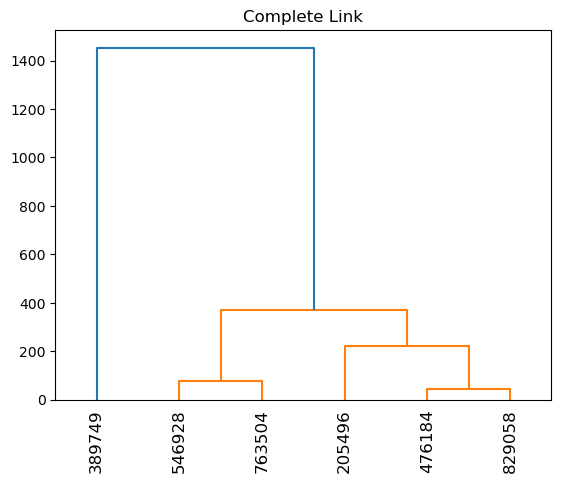

[0 1 0 2 2 0]


In [32]:
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
#mat = np.array([[0,4,25,24,9,7], [4,0,21,20,5,3], [25,21,0,1,16,18], [24,20,1,0,15,17], [9,5,16,15,0,2], [7,3,18,17,2,0] ])
#dists = squareform(matrix)
linkage_matrix = linkage(matrix, "complete")
model = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
model.fit(matrix)
dendrogram(linkage_matrix, labels=[205496, 389749, 476184, 546928, 763504, 829058], leaf_rotation=90)
plt.title("Complete Link")
plt.show()
print(model.labels_)

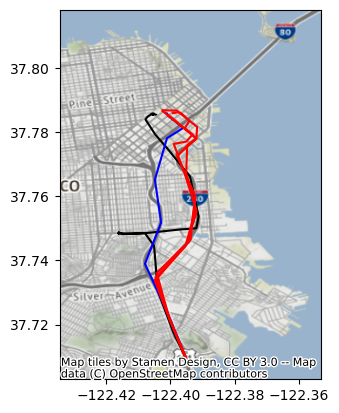

In [22]:
#line = line_intersect2[line_intersect2['trip']].isin[839469, 907466]
valList1 = [763504]

valList2 = [389749]

valList3 = [546928, 829058, 205496, 476184]

group1 = line_intersect2["trip"].isin(valList1)

group2 = line_intersect2["trip"].isin(valList2)

group3 = line_intersect2["trip"].isin(valList3)

group1 = line_intersect2[group1]
group2 = line_intersect2[group2]
group3 = line_intersect2[group3]


base = analysis2.plot(color='None', alpha = 0.1, edgecolor='None')

ax2 = group1.plot(ax = base, color='black');
ax3 = group2.plot(ax = ax2, color='blue');
ax4 = group3.plot(ax = ax3, color='red', legend = True);

ctx.add_basemap(ax4, crs = analysis2.crs.to_string(), zoom = 12)